<class 'torchvision.transforms.transforms.Compose'>


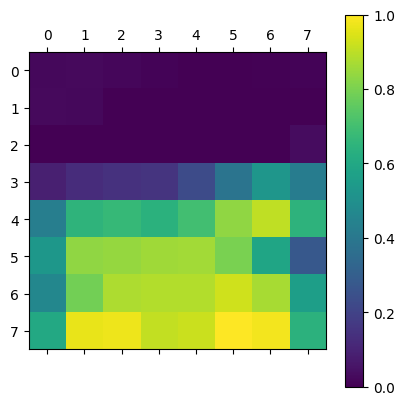

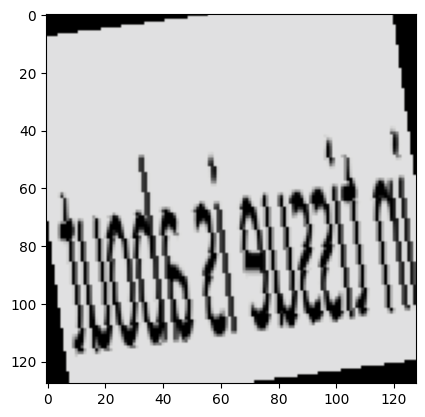

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from cnn import FontClassifierCNN  # Ensure this is correctly imported from your project structure
from augmentation import augs       # Ensure this is correctly imported from your project structure
from PIL import Image
import numpy as np
def imshow():
    img = img.numpy().transpose(1, 2, 0)  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
    std = np.array([0.229, 0.224, 0.225])  # Normalization std
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()


def get_last_conv_name(net):
    """
    Get the name of the last convolutional layer.
    """
    layer_name = None
    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            layer_name = name
    return layer_name

def grad_cam(model, image, target_class):
    """
    Generate Grad-CAM heatmap for a specific class.
    """
    model.eval()
    last_conv_layer = get_last_conv_name(model)
    features = {}
    grads = {}

    def get_features_hook(module, input, output):
        features[last_conv_layer] = output.detach()

    def get_grads_hook(module, input_grad, output_grad):
        grads[last_conv_layer] = output_grad[0].detach()

    layer = dict(model.named_modules())[last_conv_layer]
    layer.register_forward_hook(get_features_hook)
    layer.register_backward_hook(get_grads_hook)
    
    output = model(image)
    output = output[0] if isinstance(output, tuple) else output
    model.zero_grad()
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    output.backward(gradient=one_hot_output, retain_graph=True)
    
    gradients = grads[last_conv_layer]
    activations = features[last_conv_layer]
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    for i in range(pooled_gradients.size()[0]):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    
    plt.matshow(heatmap.squeeze())
    plt.colorbar()
    plt.show()

    return heatmap

def imshow(img, title):
    img = img.squeeze(0)
    img = img.numpy().transpose(1, 2, 0)  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
    std = np.array([0.229, 0.224, 0.225])  # Normalization std
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()
transform = augs()
# image_path = 'sample_eval_data/Allura/image_3.png'
image_path = 'data/test/OpenSans/image_10.png'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)
classes = [
    'AguafinaScript', 'AlexBrush', 'Allura', 'alsscrp', 'Canterbury',
    'GreatVibes', 'Holligate Signature', 'ILoveGlitter', 'JamesFajardo', 'OpenSans'
]
target_class_name = 'Holligate Signature'
target_class = classes.index(target_class_name)
model = FontClassifierCNN()
model.load_state_dict(torch.load('model/cnn_shadow.pth'))

heatmap = grad_cam(model, image, target_class)
imshow(image,'')

